In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [3]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.nan_to_num(np.concatenate((features,d)))
    return features[1:,:]

preds = dict()
window_len_list = [2,7]
for window_len in window_len_list:
    print('window_len',window_len)
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,w_pageview_features))
    features_small = price_features
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)
    classes.shape

    ### Model Training & Hyperparameter Tuning

    features_dict = {'all':features,'price':features_small}
    for features_k in features_dict.keys():
        print('features',features_k)
        features = features_dict[features_k]
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        random_grid = {'C': [0.1, 1, 5, 10], 'gamma': ['scale','auto'], 'kernel': ['rbf']}

        svc = SVC()
        svc_random = RandomizedSearchCV(estimator = svc, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 4, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        svc_random.fit(x_train, y_train)
        print(svc_random.best_params_)
        model = SVC(C=svc_random.best_params_['C'],gamma=svc_random.best_params_['gamma'],kernel=svc_random.best_params_['kernel'])
        model.fit(x_train,y_train)

        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))
        
        preds['svc_w'+str(window_len)+'_feature_'+features_k] = model.predict(x_test)[1:]

window_len 2
features all
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
	training score: 0.5672153635116598
	test score: 0.6088992974238876
features price
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.2s finished


{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
	training score: 0.5507544581618655
	test score: 0.5690866510538641
window_len 7
features all
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.5s finished


{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
	training score: 0.9435650378527185
	test score: 0.5667447306791569
features price
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
	training score: 0.5519614590502409
	test score: 0.5690866510538641


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.3s finished


In [5]:
preds.keys()

dict_keys(['svc_w2_feature_all', 'svc_w2_feature_price', 'svc_w7_feature_all', 'svc_w7_feature_price'])

### Momentum with SVC

buy&hold 6.2563280640934185
svc_w2_feature_all_cum_returns 22.976478948765397
svc_w2_feature_price_cum_returns 6.2563280640934185
svc_w7_feature_all_cum_returns 10.433127434666961
svc_w7_feature_price_cum_returns 6.2563280640934185
random_strategy_cum_returns 1.8979025023316234


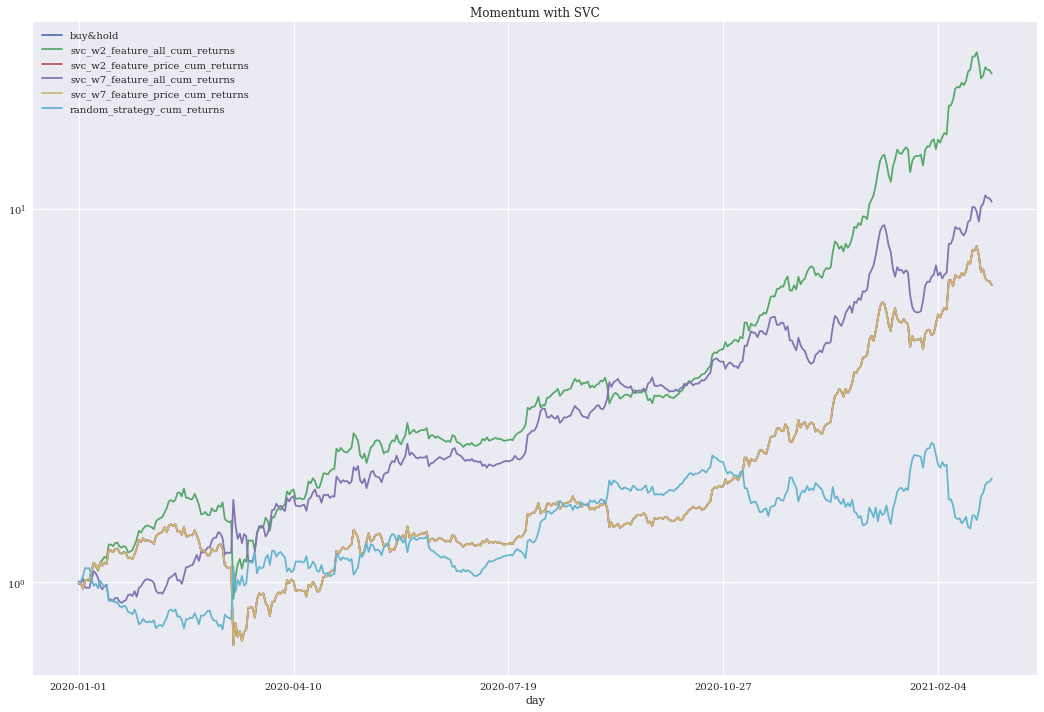

In [6]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()

#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with SVC"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:]+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

for r in plot_columns1:
    print(r, returns_data[r][-1])

### Visualizing Positions

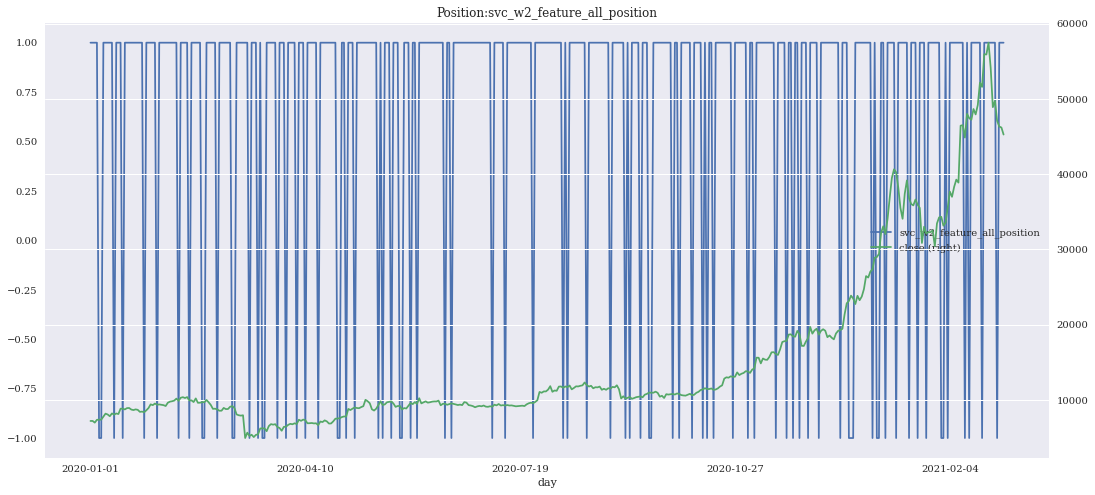

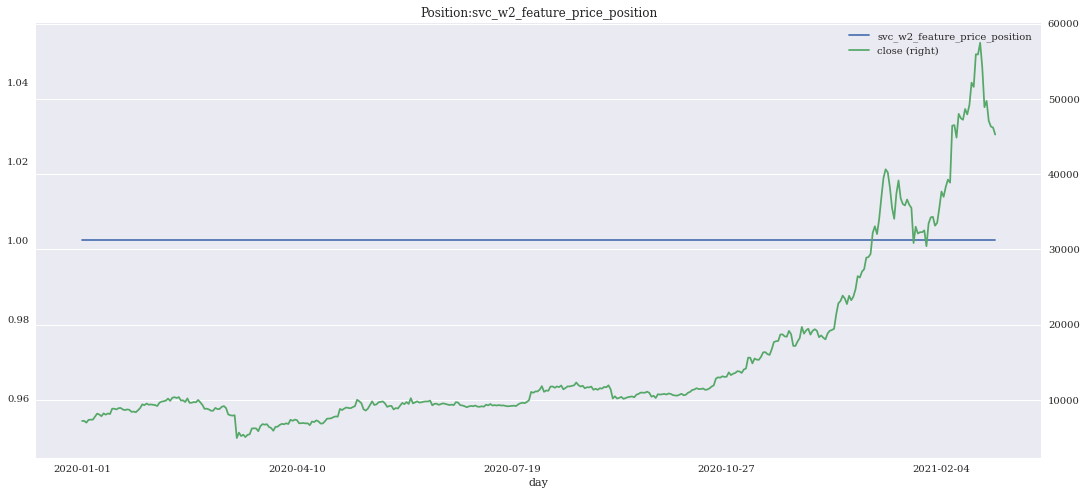

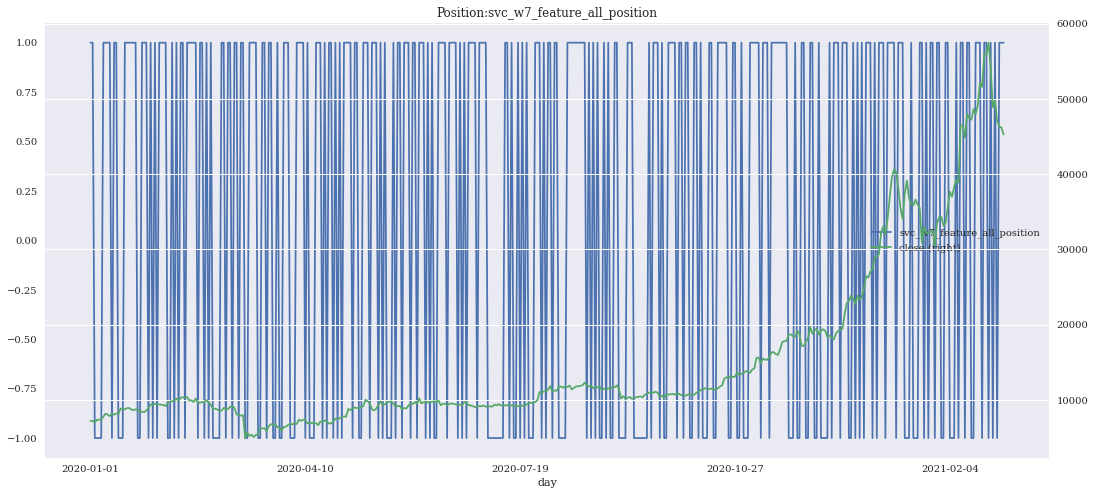

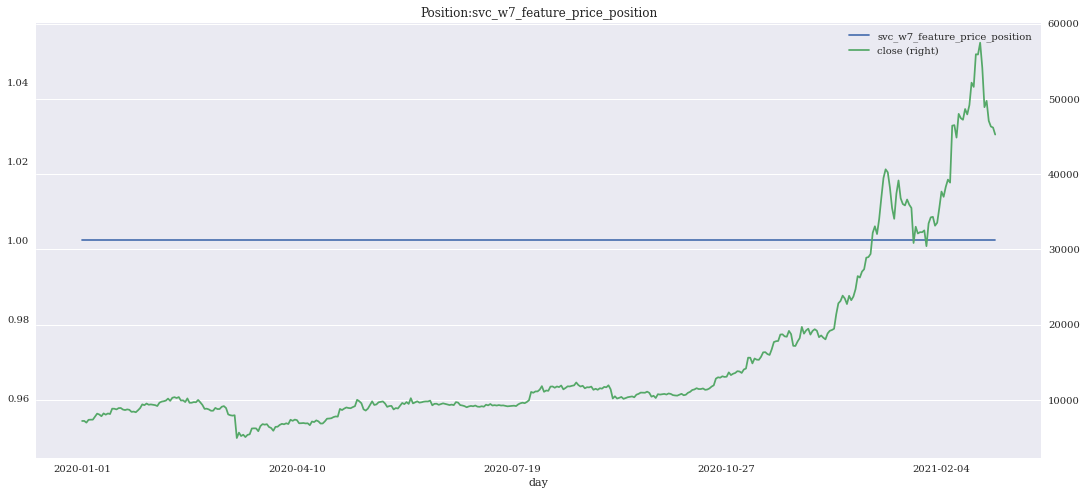

In [7]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))